# Fit Demo - Simulated Data
---------------------------
Simulate some data, fit it with Lightning, and see how close to the input SFH and parameters we get.

## Imports

In [1]:
import numpy as np
import astropy.units as u
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning

## Initialize Lightning

In [2]:
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PACS_green', 'PACS_red']

# Redshift 0, default stellar age bins
l = Lightning(filter_labels, 
              redshift=0.0,
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              print_setup_time=True)

0.051 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.547 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.636 s elapsed in dust emission model setup
2.235 s elapsed total


/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:61: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


## Fake some data

In [3]:
params = np.array([1,1,1,1,1,
                   0.3, 0.0, 0.0,
                   2, 1, 3e5, 0.1, 0.01])

Lmod, _ = l.get_model_lnu(params)

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
DL = 10 * u.Mpc

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

## Fit with `emcee`

In [4]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, True, True,
                      True, False, True, False, False])

var_dim = ~const_dim

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0, method='emcee', Nwalkers=75, Nsteps=5000, const_dim=const_dim)

100%|██████████| 5000/5000 [07:09<00:00, 11.65it/s]


Check on the acceptance fraction and construct the final chain:

In [5]:
print('MCMC mean accpetance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# The autocorrelation time is <= 500; emcee is gonna tell us that the esimate of the
# autocorrelation time is bad because we haven't run a long enough chain (it's right)
# so the below line is commented out
#print('MCMC mean autocorrelation time: %.1f' % (np.mean(mcmc.get_autocorr_time())))

MCMC mean accpetance fraction: 0.234


In [6]:
# We'll thin by a factor that's overkill since our estimate of the autocorrelation time
# may be wrong
chain = mcmc.get_chain(discard=1000, thin=250, flat=True)[-1000:, :]
logprob_chain = mcmc.get_log_prob(discard=1000, thin=250, flat=True)[-1000:]

### Chain Plot
We'll make the traditional chain plot, for the SFH:

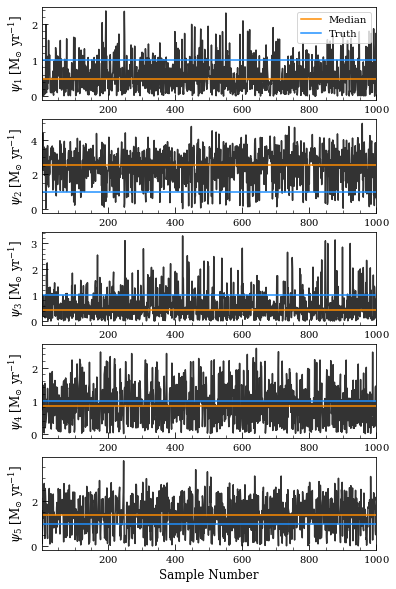

In [7]:
fig, axs = plt.subplots(5,1, figsize=(6,10))

t = np.arange(1000) + 1
for i in np.arange(5):
    axs[i].plot(t, chain[:,i], color='k', alpha=0.8)
    axs[i].axhline(np.median(chain[:,i]), color='darkorange', label='Median')
    axs[i].axhline(1, color='dodgerblue', label='Truth')
    axs[i].set_ylabel(r'$\psi_%d\ [\rm M_{\odot}\ yr^{-1}]$' % (i + 1))
    axs[i].set_xlim(1,1000)

axs[4].set_xlabel('Sample Number')

axs[0].legend(loc='upper right', frameon=True)

### Corner Plot
And now a corner plot for the whole set of parameters:

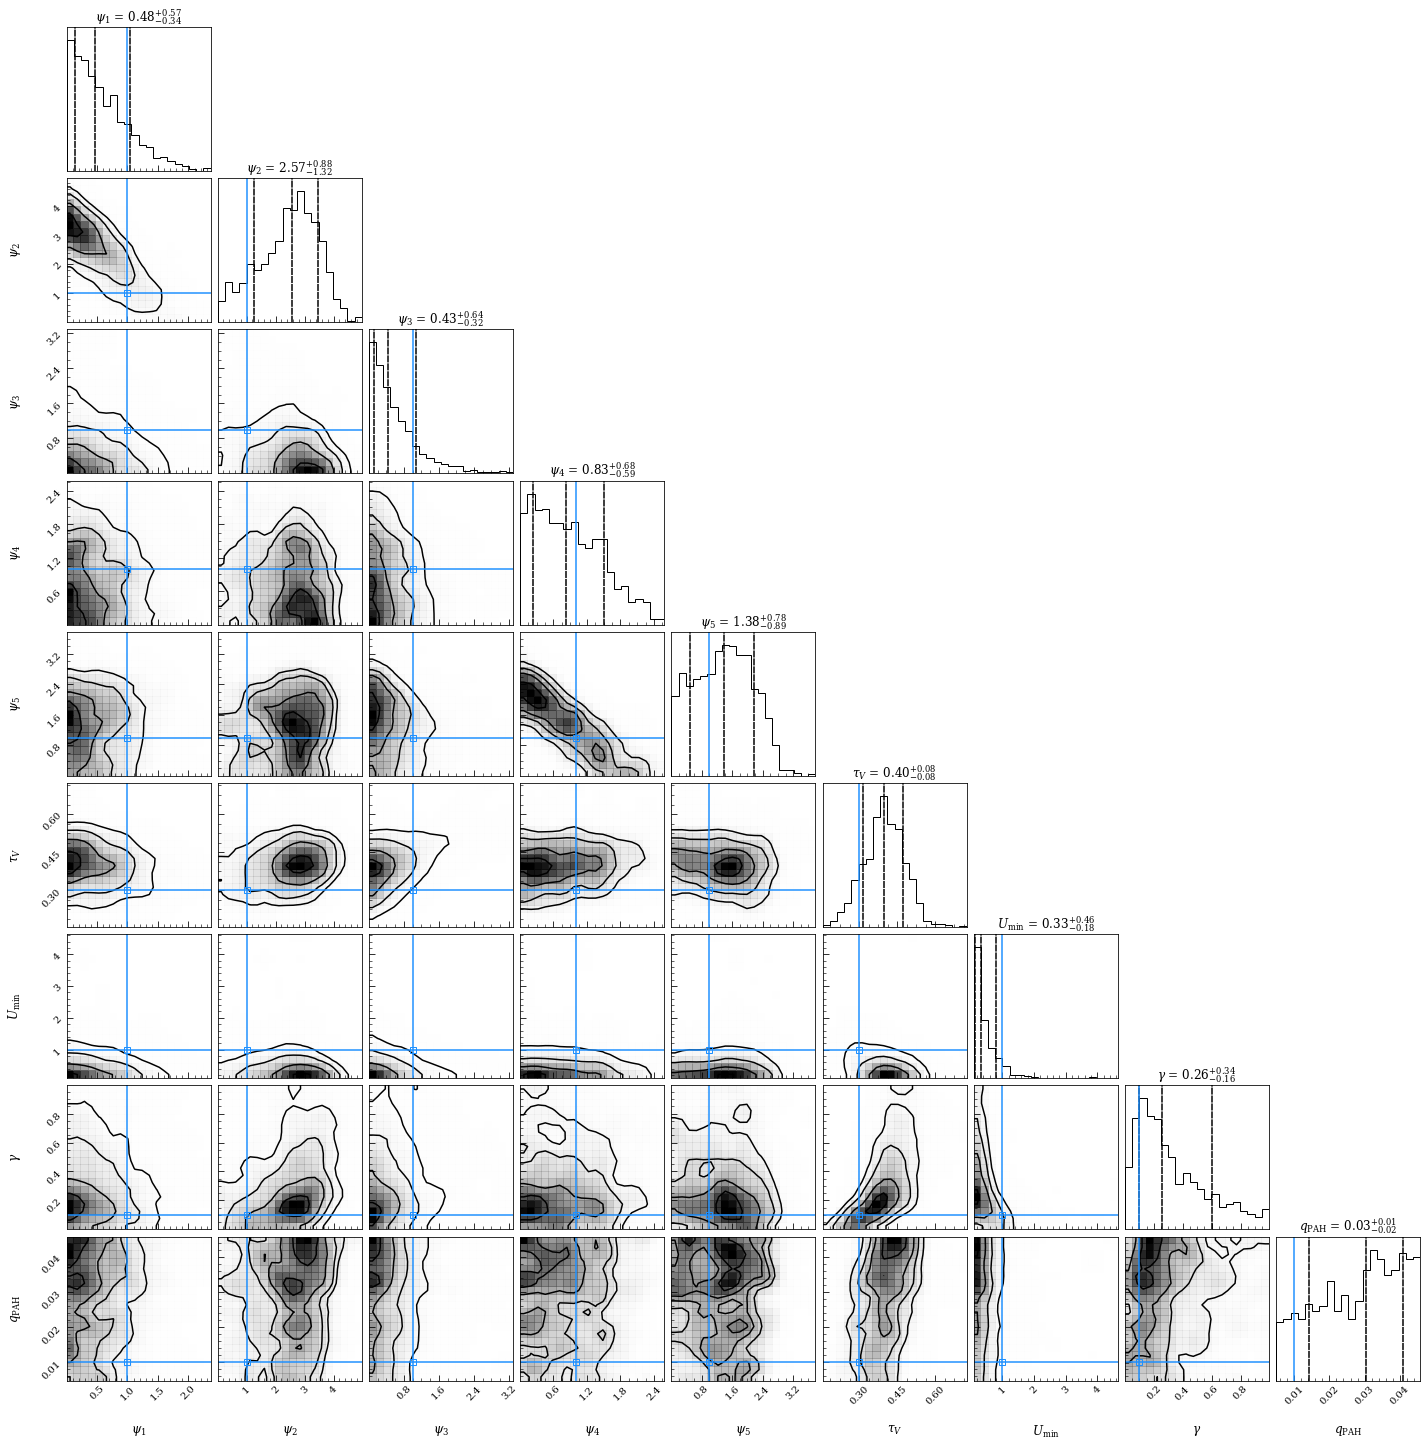

In [8]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$']

fig = corner(chain, labels=labels, quantiles=(0.16, 0.50, 0.84),
             truths=p[var_dim], truth_color='dodgerblue', smooth=1, show_titles=True)

So, not terrible, right? We might also recover the dust attenuation and emission parameters better with more extensive IR coverage.

### Best fit SED/Sampled SFH plot
This'll be our typical plot, with the best-fit SED and the 16th-84th percentile of the SFH.

In [9]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l.get_model_lnu_hires(bestfit_params)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

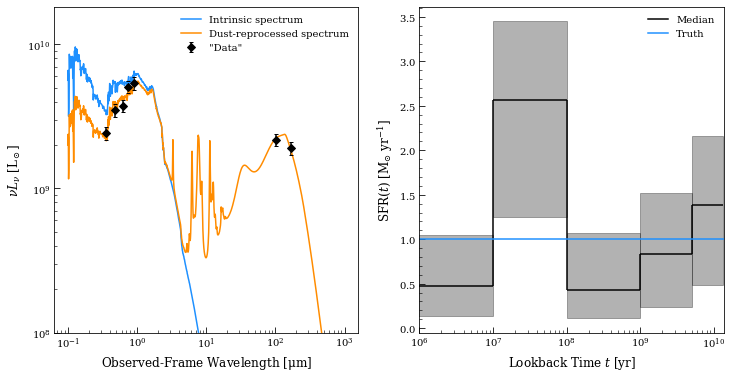

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
            color='dodgerblue', label='Intrinsic spectrum')

axs[0].plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Dust-reprocessed spectrum')

axs[0].errorbar(l.wave_obs, l.nu_obs * Lsim, yerr=l.nu_obs * Lsim_unc,
                marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
                label='"Data"')

axs[0].set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
axs[0].set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1e8,)
axs[0].legend(loc='upper right')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l.ages) - 1):
    axs[1].fill_between([l.ages[i], l.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    l1 = axs[1].hlines(sfh_q[1,i], l.ages[i], l.ages[i+1], color='k')
    if (i < len(l.ages) - 2): 
        axs[1].vlines(l.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

l2 = axs[1].axhline(1, color='dodgerblue')

axs[1].legend([l1,l2], ['Median', 'Truth'], loc='upper right')

axs[1].set_xlabel(r'Lookback Time $t$ [yr]')
axs[1].set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
axs[1].set_xscale('log')
axs[1].set_xlim(1e6,13.6*10**9)